In [1]:
#1. Module Import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

In [ ]:
''' 3. Configure hyperparameters '''
num_epochs = 10
num_classes = 525
batch_size = 32
learning_rate = 0.0001

In [ ]:
''' 4. Download Birds datasets '''
# Define transforms
transform=transforms.Compose([transforms.Resize((224,224)),transforms.RandomRotation(45),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# download the Birds dataset and
train_dataset = torchvision.datasets.ImageFolder(root="./datasets/train", transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root="./datasets/valid", transform=transform)

classes = list(train_dataset.class_to_idx.keys())

train_dataset_ADJ = 0.45
train_dataset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*train_dataset_ADJ), len(train_dataset)-int(len(train_dataset)*train_dataset_ADJ)])[0]

print('Number of train images: {}'.format(len(train_dataset)))
print('Number of validation images: {}'.format(len(val_dataset)))

Number of train images: 38085
Number of validation images: 2625
Number of test images: 2625


In [ ]:
''' 5. Load the data through dataloader '''
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [ ]:
''' 6. Checking data (1) '''
# 1. Check Length
print("Number of batches in DataLoader:", len(train_loader))

# 2. Iterate Over DataLoader
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print("Inputs shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    # Optionally, print out the actual data in the batch
    # print("Inputs:", inputs)
    # print("Labels:", labels)

    # Break after inspecting the first few batches
    if batch_idx >= 2:
        break

# 3. Access Single Batch
single_batch = next(iter(train_loader))
inputs, labels = single_batch
print("Single batch:")
print("Inputs shape:", inputs.shape)
print("Labels shape:", labels.shape)

Number of batches in DataLoader: 2645
Batch 0:
Inputs shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Batch 1:
Inputs shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Batch 2:
Inputs shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Single batch:
Inputs shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


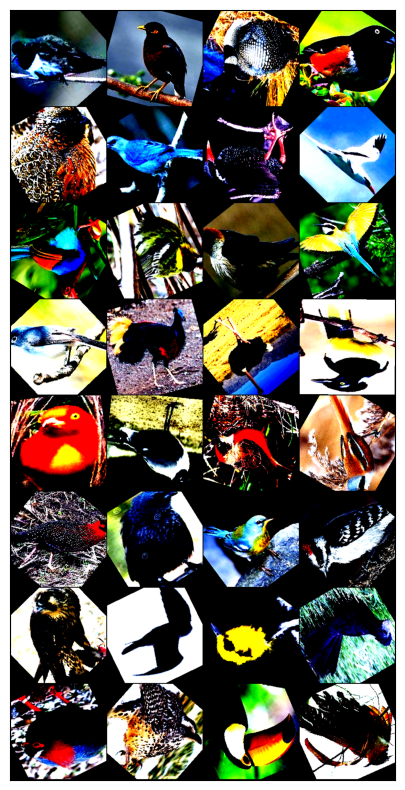

In [ ]:
''' 7. Checking data (2) '''
# Visualize one training batch
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1, 2, 0))
    break

In [ ]:
# loading the model architecture
model = torchvision.models.resnet50(pretrained=True)

# freezing all the parameters from training
for param in model.parameters():
    param.require_grad = False

# adding a fc layer with relu activation and a dropout layer to prevent overfitting then output layer with num of classes
model.fc = nn.Sequential(nn.Linear(model.fc.in_features,1024),
                         nn.ReLU(),
                         nn.Dropout(0.3),
                         nn.Linear(1024,num_classes))

c:\Users\theos\anaconda3\envs\EC4209\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\theos\anaconda3\envs\EC4209\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cpu


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

In [ ]:
def fit(model,criterion,optimizer,num_epochs=10):
    start = time.time()
    best_model = model.state_dict()
    best_acc = 0.0
    train_loss_over_time = []
    val_loss_over_time = []
    train_acc_over_time = []
    val_acc_over_time = []

    # each epoch has a training and validation phase
    for epoch in range(num_epochs):
        print(f'{epoch+1}/{num_epochs} epoch')

        for phase in ['train','val']:

            if phase == 'train':
                data_loader = train_loader
                model.train()                    # set the model to train mode
            else:
                data_loader = val_loader
                model.eval()                    # set the model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            # iterate over the data
            for inputs,labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,pred = torch.max(outputs,dim=1)
                    loss = criterion(outputs,labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # calculating the loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

            if phase == 'train':
                epoch_loss = running_loss/len(train_dataset)
                train_loss_over_time.append(epoch_loss)
                epoch_acc = running_corrects.double()/len(train_dataset)
                train_acc_over_time.append(epoch_acc)
            else:
                epoch_loss = running_loss/len(val_dataset)
                val_loss_over_time.append(epoch_loss)
                epoch_acc = running_corrects.double()/len(val_dataset)
                val_acc_over_time.append(epoch_acc)

            print(f'{phase} loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = model.state_dict()

        print('-'*60)

    total_time = (time.time() - start)/60
    print(f'training complete in: {total_time:.3f} min\nbest accuracy: {best_acc:.3f}')
    # load best model weights
    model.load_state_dict(best_model)
    loss = {'train':train_loss_over_time, 'val':val_loss_over_time}
    acc = {'train':train_acc_over_time, 'val':val_acc_over_time}
    return model,loss,acc

In [ ]:
history,loss,acc = fit(model,criterion,optimizer,num_epochs=num_epochs)

1/5 epoch


In [ ]:
# plotting the loss and accuracy curve for each phase
train_loss = loss['train']
val_loss = loss['val']
train_acc = acc['train']
val_acc = acc['val']

epochs_range = range(num_epochs)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(epochs_range,train_loss,label='train_loss')
plt.plot(epochs_range,val_loss,label='val_loss')
plt.legend(loc=0)
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range,train_acc,label='train_acc')
plt.plot(epochs_range,val_acc,label='val_acc')
plt.legend(loc=0)
plt.title('Accuracy')

In [ ]:
torch.save(model.state_dict(), './models/NomModel.pth')

#####